TP  5 : Propagation d'une maladie en Normandie
====

1 - Introduction 
------

Nous allons dans ce TP simuler la propagation d'une maladie saisonnière en Normandie. Nous utiliserons pour cela les résultats des TP précédents sur les calculs de distance. Nous ferons appel pour ce TP aux connaissances acquises dans les précédents TP ainsi qu'au cours sur les générateurs aléatoires.

Le TP sera à réaliser en python 3. Les librairies utilisées sont installées sur les machines de l'université, vous pouvez néanmoins les installer sur vos propres machines à l'aide de l'utilitaire pip présent par défaut avec python.
	
N'hésite pas à regarder régulièrement la documentation de ces librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

- Python 3: https://docs.python.org/3/
- Numpy: https://docs.scipy.org/doc/numpy/reference/
- Scipy: https://docs.scipy.org/doc/scipy/reference/
- Matplotilb: https://matplotlib.org/contents.html

**<span style="color:red"> À part si cela est précisé, vous ne devez pas utiliser directement de boucle (`for`,`while`) ou de branchement conditionnel (`if`) durant ce TP.</span>**

In [1]:
import numpy as np
import scipy as sc
import scipy.misc
import matplotlib.pyplot as plt

2 - Le début de l'épidémie
----

Dans le précédent TP nous avons calculé les coordonnées cartésiennes des villes de Normandie puis nous avons approximé la distance entre villes en utilisant une distance euclidienne entre ces points.

Reprendre dans le code du TP3, la lecture du fichier *data.pickle*.

In [2]:
import pickle

# pour lire les données sur disque avec pickle
with open('../TP3/data.pickle', 'rb') as f:  
    [ville,nom_ville,coord] = pickle.load(f)
    
R = 6367.445

def distGeo(u,v):
    u = u*np.pi/180
    v = v*np.pi/180
    
    return R*np.arccos(np.sin(u[0])*np.sin(v[0]) + np.cos(u[0])*np.cos(v[0])*np.cos(u[1] - v[1]))

def convert3D(u):
    u = u*np.pi/180
    xyz = np.zeros((u.shape[0],3))
    xyz[:,0] = R*np.cos(u[:,0])*np.sin(u[:,1])
    xyz[:,1] = R*np.cos(u[:,0])*np.cos(u[:,1])
    xyz[:,2] = R*np.sin(u[:,0])
    return xyz

Récupérez du précédent TP le code permettant d'avoir la matrice des distances entre ville et stocker la dans une matrice nommé  *d_villes*. Si vous n'avez pas fait cette question, vous pouvez utiliser le fichier *d_villes.npy* contenant cette matrice. Le fichier se charge dans python avec le code suivant :

In [3]:
print(coord)

[[49.4       0.3     ]
 [49.166667  0.7     ]
 [48.766667  1.1     ]
 ...
 [49.4       0.883333]
 [48.716667 -0.75    ]
 [49.633333  0.533333]]


Faites de même avec le fichier contenant les coordonnées 3D des villes de Normandie.

In [249]:
coord3D_villes = np.load('coord_villes.npy')
print(coord3D_villes)

[[  -43.56911189 -4160.39162835  4820.12438213]
 [  -31.46683174 -4160.500764    4820.12438213]
 [  -30.2770257  -4163.31316923  4817.70304032]
 ...
 [  123.03601844 -4105.24292174  4865.81940887]
 [  112.28810824 -4105.55096047  4865.81940887]
 [   97.92261372 -4104.50269784  4867.01392983]]


Comme dans le TP précédent, affichez les villes normandes à l’écran avec la
fonction `plt.scatter` de matplotlib.

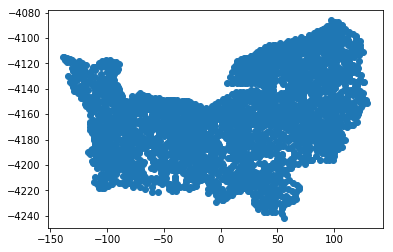

In [250]:
plt.scatter(coord3D_villes[:,0], coord3D_villes[:,1])
plt.show()

Ajoutez aux arguments de la fonction `plt.scatter` de la question précédente les
arguments `color='b',marker='s',s=5,alpha=0.1`. À votre avis que font ces
arguments ?

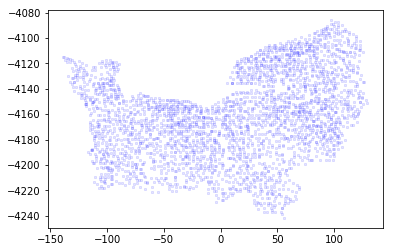

In [251]:
plt.scatter(coord3D_villes[:,0], coord3D_villes[:,1], color='b', marker='s', s=5, alpha=0.1)
plt.show()

Pour le début de l'épidémie nous allons considérer que chaque ville à un risque de $\dfrac{1}{500}$ d'être un foyer de l'infection. Nous allons construire un vecteur contenant autant d'éléments qu'il y a de ville et dont les valeurs sont soit True (si la ville est un foyer initiale de l'infection) soit False. Pour construire ce vecteur, faites les opérations suivantes :


1. Définissez une variable $n$ contenant le nombre de villes de Normandie.
2. Tirez au hasard selon une loi uniforme $n$ valeurs entre 0 et 1.
3. Testez si les valeurs du vecteur précédent sont inférieures à $\dfrac{1}{500}$. Le résultat de chaque test formera le vecteur `ville_src` que l'on souhaite construire. Vous n'avez pas besoin de `for` pour cette question

In [252]:
n = len(d_villes)
print(n)
hasar = np.random.rand(n)
print(hasar)
ville_src = hasar < (1.0/500)
print(ville_src)

2992
[5.40713803e-01 9.24305549e-01 9.62048233e-01 ... 6.01554382e-01
 7.49830623e-01 3.88917537e-04]
[False False False ... False False  True]


Reprenez la précédente figure. Superposer sur l'image des points rouges correspondants aux villes contaminées. Si vous relancez le code précédent, les villes en rouges devraient changer.

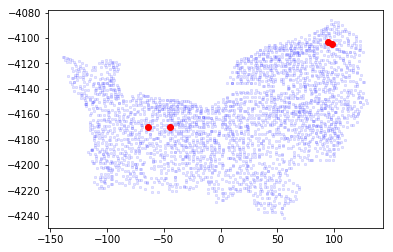

In [253]:
plt.scatter(coord3D_villes[:,0], coord3D_villes[:,1], color='b', marker='s', s=5, alpha=0.1)

plt.scatter(coord3D_villes[ville_src, 0], coord3D_villes[ville_src, 1], color='r', marker='o')

plt.show()

3 - La propagation de la maladie
-------

On va dans cette partie modéliser la propagation de la maladie. On va supposer
que les villes nouvelles contaminées suivent une loi normale centrée sur les villes déjà
infectées.

Définissez un variable $s$ égale à 4. Vous pourrez changer par la suite cette valeur
pour accélérer ou ralentir la propagation de la maladie.

In [254]:
s = 4
print(d_villes.shape)

(2992, 2992)


Tirez selon une loi normale centrée réduite les valeurs d’une matrice nommée `nouvelle_ville_contamine_valeur`. Cette matrice aura la même taille que la matrice `d_villes`. Elle va nous permettre de choisir les villes nouvellement contaminées en fonction de leurs distances aux villes contaminées.

In [255]:
nouvelle_ville_contamine_valeur = np.random.standard_normal(d_villes.shape)

Multipliez les valeurs de la matrice `nouvelle_ville_contamine_valeur` par $s$ pour fixer la vitesse de propagation. 

In [256]:
nouvelle_ville_contamine_valeur = nouvelle_ville_contamine_valeur*s

Construisez une nouvelle matrice `nouvelle_ville_contamine` qui contient True pour les valeurs dans `nouvelle_ville_contamine_valeur` dont la valeur absolue est plus grand que les valeurs dans `d_villes` et False pour les autres. Cette matrice permet de connaître la contamination potentielle des villes. Les villes en colonne indiquent si la ville serait contaminée dans l'hypothèse où la ville indiquée par la ligne est déjà contaminée. 

In [258]:
nouvelle_ville_contamine = np.abs(nouvelle_ville_contamine_valeur) > d_villes
print(nouvelle_ville_contamine)

[[ True False False ... False False False]
 [False  True  True ... False False False]
 [False  True  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]


Multipliez la matrice précédente par la matrice `ville_src` et sommez les valeurs suivant les colonnes. Numpy remplacera les valeurs True par 1 et False par 0 pour faire le calcul. Cela produira un vecteur qui compte pour chaque ville le nombre de villes qui sont sources de sa contamination. Si la valeur est 0,la ville n'est pas encore contaminée. 

In [259]:
v = np.sum((nouvelle_ville_contamine*ville_src), axis=1)
print(v)

[0 0 0 ... 0 0 1]


Testez si les valeurs du vecteur précédent sont supérieures strictement à 0. Si c'est le cas, c'est-à-dire que la ville est contaminée.

In [261]:
v=v > 0

Reprenez la figure de la question précédente et affichez-y les villes nouvellement contaminées en vert. Que remarquez-vous sur les villes contaminées au début de l'épidémie ?

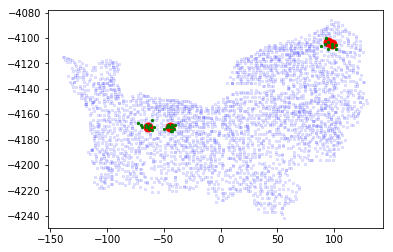

In [281]:
plt.scatter(coord3D_villes[:,0], coord3D_villes[:,1], color='b', marker='s', s=5, alpha=0.1)

plt.scatter(coord3D_villes[ville_src, 0], coord3D_villes[ville_src, 1], color='red', s=80)

plt.scatter(coord3D_villes[v, 0], coord3D_villes[v, 1], color='green', marker='o', s=5)

plt.show()

À l'aide d'une boucle `for` réitérer plusieurs fois les opérations précédentes pour voir la propagation de la maladie au bout d'un certain temps. À chaque itération, on prendra comme `ville_src`, toutes les villes précédemment contaminées. 

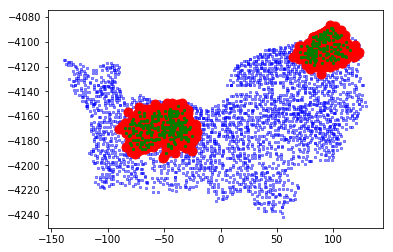

In [282]:
for i in range(5):
    s = 4
    nouvelle_ville_contamine_valeur = np.random.standard_normal(d_villes.shape)
    
    nouvelle_ville_contamine_valeur = nouvelle_ville_contamine_valeur*s
    
    nouvelle_ville_contamine = np.abs(nouvelle_ville_contamine_valeur) > d_villes
    
    v = np.sum((nouvelle_ville_contamine*ville_src), axis=1)
    
    v=v > 0
    ville_avant_src = ville_src
    ville_src = v
    
    plt.scatter(coord3D_villes[:,0], coord3D_villes[:,1], color='b', marker='s', s=5, alpha=0.1)
    plt.scatter(coord3D_villes[v, 0], coord3D_villes[v, 1], color='red', s=80)
    plt.scatter(coord3D_villes[ville_avant_src, 0], coord3D_villes[ville_avant_src, 1], color='green', marker='o', s=5)
    
    

plt.show()
    

Création d'une animation (partie bonus)
-----

Étudiez le code suivant. Que fait ce code ? 

RuntimeError: Error creating movie, return code: 1

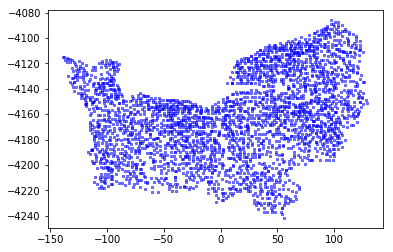

In [292]:
import matplotlib.animation as animation

s = 4
n = len(d_villes)
hasar = np.random.rand(n)
ville_src = hasar < (1.0/500)

fig = plt.figure()
def updatefig(i):
    global ville_src
    ville_src_contamine = ville_src * (np.abs(np.random.standard_normal(d_villes.shape)))
    
    ville_contamine = np.sum(ville_src_contamine, axis=1) > 0
    
    fig.clear()
    
    plt.scatter(coord3D_villes[:,0],coord3D_villes[:,1],color='b',marker='s',s=5,alpha=0.5)
    plt.scatter(coord3D_villes[ville_contamine:,0],coord3D_villes[ville_contamine:,1],color='g',marker='s',s=5,alpha=0.5)
    plt.scatter(coord3D_villes[ville_src:,0],coord3D_villes[ville_src:,1],color='r',marker='s',s=5,alpha=0.5)
    
    plt.draw()
    ## points = np.concatenate([points,x],axis=0)
    ville_src = ville_contamine

anim = animation.FuncAnimation(fig, updatefig, 20)
anim.save("test.mp4", fps=5)


In [1]:
%%HTML
<video width="320" height="240" controls>
  <source src="test.mp4" type="video/mp4">
</video>

Reprenez le code de la partie précédente et au lieu d'afficher le résultat à l'écran, faites une petite animation de la propagation de la maladie. 

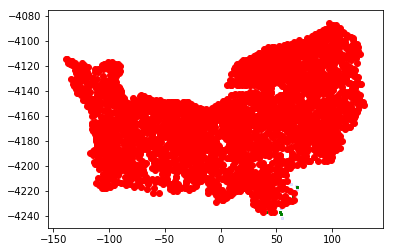